<a href="https://colab.research.google.com/github/ysfzkn/covid_mobility_data_analysis/blob/main/Final_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIL 366 Data Mining Final Project

## Feyza Becer - Yusuf Özkan

### Amaç - Purpose

* Vaka sayılarının toplu taşımadaki hareketliliğe ve evdeki insan yoğunluğuna etkisi

* The Effect of Covid-19 Cases to Change in Transit and Residential Category in Google Mobility Data in Turkey



In [290]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import plotly.graph_objs as go
import missingno as msno
import plotly.offline as py
import plotly.express as px
import seaborn as sns

#https://www.google.com/covid19/mobility/

mobility = pd.read_csv('2020_TR_Region_Mobility_Report.csv')
mobility = mobility.rename(columns={'transit_stations_percent_change_from_baseline':'transit_stations',
                                    'residential_percent_change_from_baseline':'residential_per'})

residential = mobility[['residential_per']].copy()
transit = mobility[['transit_stations']].copy()

# https://covid19.saglik.gov.tr/TR-66935/genel-koronavirus-tablosu.html

covid = pd.read_excel("tr_data.xlsx")
#covid = covid.astype(np.uint8,errors="ignore")
covid

,Date,Case
0,2020-03-11,1
1,2020-03-12,0
2,2020-03-13,1
3,2020-03-14,3
4,2020-03-15,13
...,...,...
291,2020-12-27,2806
292,2020-12-28,2816
293,2020-12-29,2783
294,2020-12-30,2612


In [291]:
mobility.isnull().sum() # missing values

country_region_code                                        0
country_region                                             0
sub_region_1                                             321
sub_region_2                                           25965
metro_area                                            167657
iso_3166_2_code                                       142013
census_fips_code                                      167657
place_id                                                   0
date                                                       0
retail_and_recreation_percent_change_from_baseline     65792
grocery_and_pharmacy_percent_change_from_baseline      61553
parks_percent_change_from_baseline                     72471
transit_stations                                       79934
workplaces_percent_change_from_baseline                 8787
residential_per                                        69006
dtype: int64

In [292]:
# Toplu taşımadaki hareket datasındaki NaN veriler atıldı düzenlendi ve gruplandı.

transit.index = pd.DatetimeIndex(mobility['date'])
transit = transit.dropna()
transit.index =  pd.to_datetime(transit.index, format = '%Y-%m-%d')
transit.index = transit.index.strftime('%Y-%m-%d')
transit.index =  pd.to_datetime(transit.index, format = '%Y-%m-%d')
transit = transit.reset_index()
transit = transit.groupby(transit.date).mean()

transit_grouped = transit.groupby([transit.index.month]).mean()

transit

,transit_stations
date,
2020-02-15,-11.630872
2020-02-16,-3.076389
2020-02-17,-2.501706
2020-02-18,-2.519164
2020-02-19,-5.498270
...,...
2020-12-27,-74.160142
2020-12-28,-23.770764
2020-12-29,-19.885813


### **Günlük Vaka Sayılarına Göre Clustering**



In [354]:
# Tarih ve günlük yeni vaka sayıları dataframe yapıldı

data = {'date':covid["Date"].values,
        'Cases':covid["Case"].values}

df = pd.DataFrame(data)

# Tarih index kısmına alındı ve df daha düzgün hale getirildi.

df.index =  pd.to_datetime(df["date"], format = '%d.%m.%Y')
df.index = df.index.strftime('%Y-%m-%d')
df.index =  pd.to_datetime(df.index, format = '%Y-%m-%d')

df

,date,Cases
date,,
2020-03-11,2020-03-11,1
2020-03-12,2020-03-12,0
2020-03-13,2020-03-13,1
2020-03-14,2020-03-14,3
2020-03-15,2020-03-15,13
...,...,...
2020-12-27,2020-12-27,2806
2020-12-28,2020-12-28,2816
2020-12-29,2020-12-29,2783


In [355]:
### Date'lere göre case değerlerinin plotta çizdirilmesi

fig = px.line(df, x='date', y="Cases")
fig.show()
df = df.drop(columns = 'date')

#### Vaka Sayılarının Toplu Taşıma Kullanımına Etkisi

In [356]:
### Toplu taşıma verilerinin Date'lere göre plotta çizdirilmesi 

transit['date'] = transit.index.copy()
fig = px.line(transit, x='date', y="transit_stations")
fig.show()
transit = transit.drop(columns = 'date')

In [357]:
### Transit verileri ile Vaka sayılarını aynı dataframede birleştirdik.

merged_df = pd.merge(transit, df, how='inner', on='date')
merged_df

,transit_stations,Cases
date,,
2020-03-11,-1.694444,1
2020-03-12,3.056338,0
2020-03-13,6.630508,1
2020-03-14,5.500000,3
2020-03-15,-4.069444,13
...,...,...
2020-12-27,-74.160142,2806
2020-12-28,-23.770764,2816
2020-12-29,-19.885813,2783


In [358]:
# Cluster analizinde kullanılacak k için optimum değer SSE yöntemiyle tespit edildi.

sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(merged_df)
    sse.append(km.inertia_)

transit['date'] = transit.index.copy()
fig = px.line(x=list_k, y=sse , labels={
                     "x": "Cluster",
                     "y": "SSE"
                 },
                title="SSE Analysis")
fig.show()

In [359]:
### k=3 için fit ve predict işlemleri uygulandı.

km = KMeans(n_clusters=3,init='k-means++',random_state=0)
km.fit(merged_df)
y = km.predict(merged_df)
y_kmeans= km.fit_predict(merged_df)

merged_df["label"] = y

In [299]:
# Finding Silhouette Score:  < silhouette score is a metric used to calculate the goodness of a clustering technique. >
from sklearn.metrics import silhouette_score

print('Silhoutte score of our model is ' + str(silhouette_score(merged_df, km.labels_)))

Silhoutte score of our model is 0.6376352858475169


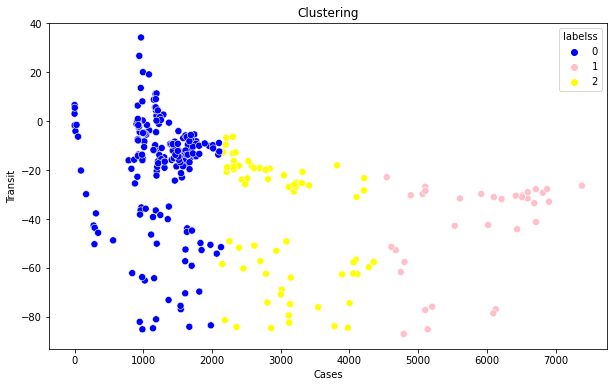

In [361]:
### Kümelerin görselleştirilmesi

plt.figure(figsize=(10,6))
merged_df['labelss'] = km.labels_
sns.scatterplot(x = 'Cases',y = 'transit_stations', hue="labelss",  
                 palette=['blue','pink','yellow'], legend='full',data = merged_df  ,s = 50 )
plt.xlabel('Cases')
plt.ylabel('Transit') 
plt.title('Clustering')
plt.show()

In [362]:
### null değer var mı diye kontrol edildi.
merged_df.isnull().sum()


transit_stations    0
Cases               0
label               0
labelss             0
dtype: int64

In [303]:
Y = merged_df.iloc[:, [0,1]].values


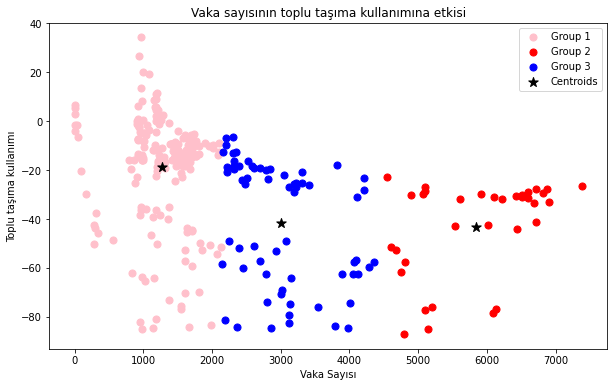

In [363]:
### Kümelerin merkez noktalarıyla birlikte görselleştirilmesi

plt.figure(figsize=(10,6))
plt.scatter(Y[y_kmeans == 0, 1], Y[y_kmeans == 0, 0], s = 50, c = 'pink', label = 'Group 1')
plt.scatter(Y[y_kmeans == 1, 1], Y[y_kmeans == 1, 0], s = 50, c = 'red', label = 'Group 2')
plt.scatter(Y[y_kmeans == 2, 1], Y[y_kmeans == 2, 0], s = 50, c = 'blue', label = 'Group 3')
plt.scatter(km.cluster_centers_[:, 1], km.cluster_centers_[:, 0], s = 100, c = 'black',marker='*', label = 'Centroids')
plt.title('Vaka sayısının toplu taşıma kullanımına etkisi')
plt.xlabel('Vaka Sayısı')
plt.ylabel('Toplu taşıma kullanımı')
plt.legend()
plt.show()

In [305]:
km.cluster_centers_

array([[ -18.75332048, 1268.96954315],
       [ -43.16712833, 5839.47058824],
       [ -41.64723443, 3003.70769231]])

In [306]:
### 3D çizim

merged_df["Date"] = merged_df.index.copy()
merged_df['Date'] = pd.to_numeric(pd.to_datetime(merged_df['Date']))

x = merged_df[['Cases', 'transit_stations']].values
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0)
kmeans.fit(x)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_


merged_df['labels'] =  labels
trace1 = go.Scatter3d(
    x= merged_df.index,
    y= merged_df['Cases'],
    z= merged_df['transit_stations'],
    mode='markers',
     marker=dict(
        color = labels, 
        size= 8,
        line=dict(
            color= merged_df['labels'],
            width= 16
        ),
        opacity=0.8
     )
)
df = [trace1]

layout = go.Layout(
    title = 'Character vs Gender vs Alive or not',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0  
    ),
    scene = dict(
            xaxis = dict(title  = 'Date'),
            yaxis = dict(title  = 'Cases'),
            zaxis = dict(title  = 'transit_stations')
        )
)

fig = go.Figure(data = df, layout = layout)
py.iplot(fig)

### Vaka Sayılarının Evde Kalma Oranına etkisi

In [310]:
# Toplu taşımadaki hareket datasındaki NaN veriler atıldı düzenlendi ve gruplandı.
residential = mobility[['residential_per']].copy()

residential.index = pd.DatetimeIndex(mobility['date'])
residential = residential.dropna()
residential.index =  pd.to_datetime(residential.index, format = '%Y-%m-%d')
residential.index = residential.index.strftime('%Y-%m-%d')
residential.index =  pd.to_datetime(residential.index, format = '%Y-%m-%d')
residential = residential.reset_index()
residential = residential.groupby(residential.date).mean()

residential_grouped = residential.groupby([residential.index.month]).mean()
residential

,residential_per
date,
2020-02-15,1.150171
2020-02-16,0.576923
2020-02-17,-1.292537
2020-02-18,-1.875740
2020-02-19,-1.709581
...,...
2020-12-27,22.079422
2020-12-28,10.414835
2020-12-29,10.917582


In [364]:
### Date'lere göre residential değerlerinin görselleştirilmesi

residential['date'] = residential.index.copy()
fig = px.line(residential, x='date', y="residential_per")
fig.show()
residential = residential.drop(columns = 'date')

In [365]:
### Vaka sayıları date'lere göre df2'de tutuldu
df2 = pd.DataFrame(data)
df2.index = df2['date']
df2 = df2.drop(columns = 'date')
df2

,Cases
date,
2020-03-11,1
2020-03-12,0
2020-03-13,1
2020-03-14,3
2020-03-15,13
...,...
2020-12-27,2806
2020-12-28,2816
2020-12-29,2783


In [366]:
### Vaka sayıları ile residential değerleri aynı dataframede birleştirildi.
merged_df2 = pd.merge(residential, df2, how='inner', on='date')
merged_df2

,residential_per,Cases
date,,
2020-03-11,-2.205357,1
2020-03-12,-2.668657,0
2020-03-13,-0.665663,1
2020-03-14,0.679310,3
2020-03-15,1.194805,13
...,...,...
2020-12-27,22.079422,2806
2020-12-28,10.414835,2816
2020-12-29,10.917582,2783


In [367]:
# Cluster analizinde kullanılacak k için optimum değer SSE yöntemiyle tespit edildi.

sse2 = []
list_k2 = list(range(1, 10))

for k in list_k2:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(merged_df2)
    sse2.append(kmeans.inertia_)

fig = px.line(x=list_k2, y=sse2 , labels={
                     "x": "Cluster",
                     "y": "SSE"
                 },
                title="SSE Analysis")
fig.show()

In [315]:
### k=3 değerine göre fit ve predict işlemlerinin yapılması

km2 = KMeans(n_clusters=3,init='k-means++',random_state=0)
km2.fit(merged_df2)
y = km2.predict(merged_df2)
y_kmeans= km2.fit_predict(merged_df2)

merged_df2["label"] = y

#The new dataframe with the clustering done

In [368]:
### Kümelerin görselleştirilmesi
labels = km2.labels_

fig = go.Figure(data=go.Scattergl(
    x= merged_df2['Cases'],
    y= merged_df2['residential_per'],
    mode='markers',
    marker=dict(
        color=labels,
        size= 10,
        colorscale='Viridis',
        line_width=1
    )
))

fig.show()

In [317]:
print('Silhoutte score of our model is ' + str(silhouette_score(merged_df2, km2.labels_)))


Silhoutte score of our model is 0.6387612069321444


In [318]:
merged_df2.isnull().sum()


residential_per    0
Cases              0
label              0
dtype: int64

In [319]:
X= merged_df2.iloc[:, [0,1]].values

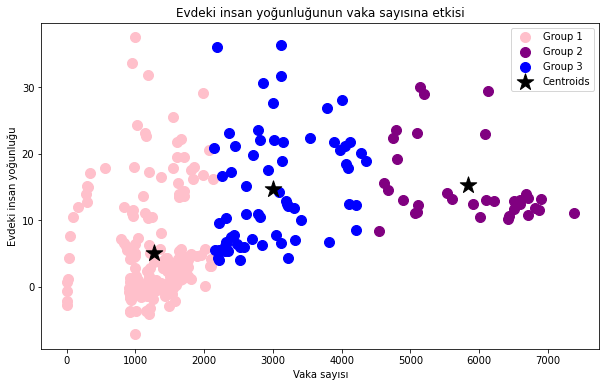

In [320]:
plt.figure(figsize=(10,6))
plt.scatter(X[y_kmeans == 0, 1], X[y_kmeans == 0, 0], s = 100, c = 'pink', label = 'Group 1')
plt.scatter(X[y_kmeans == 1, 1], X[y_kmeans == 1, 0], s = 100, c = 'purple', label = 'Group 2')
plt.scatter(X[y_kmeans == 2, 1], X[y_kmeans == 2, 0], s = 100, c = 'blue', label = 'Group 3')
plt.scatter(km2.cluster_centers_[:, 1], km2.cluster_centers_[:, 0], s = 300, c = 'black',marker='*', label = 'Centroids')
plt.title('Evdeki insan yoğunluğunun vaka sayısına etkisi')
plt.xlabel('Vaka sayısı')
plt.ylabel('Evdeki insan yoğunluğu')
plt.legend()
plt.show()

In [321]:
### 3D çizim
merged_df2["Date"] = merged_df2.index.copy()
merged_df2['Date'] = pd.to_numeric(pd.to_datetime(merged_df2['Date']))

x = merged_df2[['Cases', 'residential_per']].values
kmeans2 = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0)
kmeans2.fit(x)
labels = kmeans2.labels_
centroids = kmeans2.cluster_centers_


merged_df2['labels'] =  labels
trace1 = go.Scatter3d(
    x= merged_df2.index,
    y= merged_df2['Cases'],
    z= merged_df2['residential_per'],
    mode='markers',
     marker=dict(
        color = labels, 
        size= 8,
        line=dict(
            color= merged_df2['labels'],
            width= 16
        ),
        opacity=0.8
     )
)
df2 = [trace1]

layout = go.Layout(
    title = 'Character vs Gender vs Alive or not',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0  
    ),
    scene = dict(
            xaxis = dict(title  = 'Date'),
            yaxis = dict(title  = 'Cases'),
            zaxis = dict(title  = 'residential_per')
        )
)

fig = go.Figure(data = df2, layout = layout)
py.iplot(fig)

### Haftalık Olarak  İnceleme



In [322]:
# Evdeki insan yoğunluğunun haftalık olarak analiz edilmesi

data_columns = ['Cases', 'residential_per'] 
data_weekly_mean = merged_df2[data_columns].resample('W').mean() # W stands for weekly
data_weekly_mean

,Cases,residential_per
date,,
2020-03-15,3.600000,-0.733112
2020-03-22,174.000000,10.890932
2020-03-29,1140.142857,17.849986
2020-04-05,2550.285714,20.833476
2020-04-12,4269.571429,23.217805
2020-04-19,4192.857143,20.313318
2020-04-26,3403.428571,23.735054
2020-05-03,2273.571429,21.947487
2020-05-10,1801.714286,18.098502


In [323]:
km_w = KMeans(n_clusters=3,init='k-means++',random_state=0)
km_w.fit(data_weekly_mean)
y_w = km_w.predict(data_weekly_mean)
y_kmeans_w= km_w.fit_predict(data_weekly_mean)

data_weekly_mean["label"] = y_w

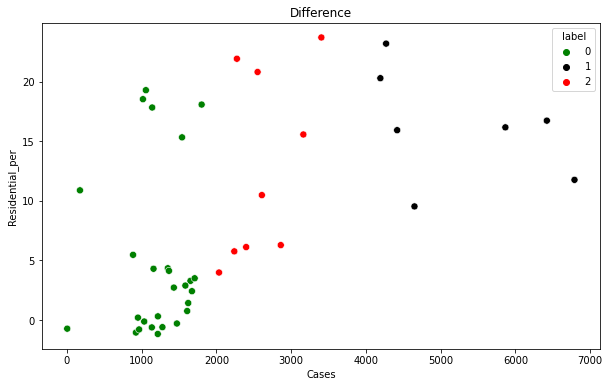

In [324]:
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'Cases',y = 'residential_per', hue="label",  
                 palette=['green','black','red'], legend='full',data = data_weekly_mean  ,s = 50 )
plt.xlabel('Cases')
plt.ylabel('Residential_per') 
plt.title('Difference')
plt.show()

In [369]:
###Haftalık verideki kümelerin görselleştirilmesi
labels = km_w.labels_

fig = go.Figure(data=go.Scattergl(
    x= data_weekly_mean['Cases'],
    y= data_weekly_mean['residential_per'],
    mode='markers',
    marker=dict(
        color=labels,
        size= 10,
        colorscale='Viridis',
        line_width=1
    )
))

fig.show()

In [326]:
Z= data_weekly_mean.iloc[:, [0,1]].values

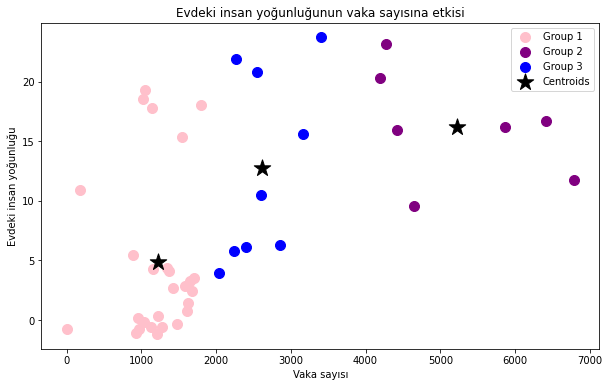

In [327]:
plt.figure(figsize=(10,6))
plt.scatter(Z[y_kmeans_w == 0, 0], Z[y_kmeans_w == 0, 1], s = 100, c = 'pink', label = 'Group 1')
plt.scatter(Z[y_kmeans_w == 1, 0], Z[y_kmeans_w == 1, 1], s = 100, c = 'purple', label = 'Group 2')
plt.scatter(Z[y_kmeans_w == 2, 0], Z[y_kmeans_w == 2, 1], s = 100, c = 'blue', label = 'Group 3')
plt.scatter(km_w.cluster_centers_[:, 0], km_w.cluster_centers_[:, 1], s = 300, c = 'black',marker='*', label = 'Centroids')
plt.title('Evdeki insan yoğunluğunun vaka sayısına etkisi')
plt.xlabel('Vaka sayısı')
plt.ylabel('Evdeki insan yoğunluğu')
plt.legend()
plt.show()

In [328]:
# toplu taşımadaki insan sayısının haftalık olarak analiz edilmesi
data_columns_transit = ['Cases', 'transit_stations']
data_weekly_mean2 = merged_df[data_columns_transit].resample('W').mean() # W stands for weekly
data_weekly_mean2

,Cases,transit_stations
date,,
2020-03-15,3.600000,1.884592
2020-03-22,174.000000,-26.936937
2020-03-29,1140.142857,-53.018783
2020-04-05,2550.285714,-62.764514
2020-04-12,4269.571429,-69.331451
2020-04-19,4192.857143,-65.371227
2020-04-26,3403.428571,-69.154720
2020-05-03,2273.571429,-65.165367
2020-05-10,1801.714286,-58.164642


In [329]:
km2_w = KMeans(n_clusters=3,init='k-means++',random_state=0)
#Fitting the input data
km2_w.fit(data_weekly_mean2)
#predicting the labels of the input data
y_w = km2_w.predict(data_weekly_mean2)
y_kmeans_w= km2_w.fit_predict(data_weekly_mean2)

#adding the labels to a column named label
data_weekly_mean2["label"] = y_w
data_weekly_mean2.isnull().sum()

Cases               0
transit_stations    0
label               0
dtype: int64

In [330]:
Z= data_weekly_mean2.iloc[:, [0,1]].values

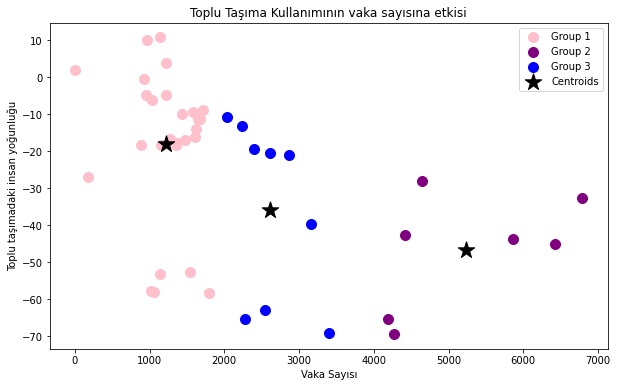

In [331]:
plt.figure(figsize=(10,6))
plt.scatter(Z[y_kmeans_w == 0, 0], Z[y_kmeans_w == 0, 1], s = 100, c = 'pink', label = 'Group 1')
plt.scatter(Z[y_kmeans_w == 1, 0], Z[y_kmeans_w == 1, 1], s = 100, c = 'purple', label = 'Group 2')
plt.scatter(Z[y_kmeans_w == 2, 0], Z[y_kmeans_w == 2, 1], s = 100, c = 'blue', label = 'Group 3')
plt.scatter(km2_w.cluster_centers_[:, 0], km2_w.cluster_centers_[:, 1], s = 300, c = 'black',marker='*', label = 'Centroids')
plt.title('Toplu Taşıma Kullanımının vaka sayısına etkisi')
plt.xlabel('Vaka Sayısı')
plt.ylabel('Toplu taşımadaki insan yoğunluğu')
plt.legend()
plt.show()

#### **Random Forest Forecasting**



In [332]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble._forest import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

#### Random Forest Forecasting for Residential Values

In [333]:
data_predict = data_weekly_mean[['Cases','residential_per']]
data_predict

,Cases,residential_per
date,,
2020-03-15,3.600000,-0.733112
2020-03-22,174.000000,10.890932
2020-03-29,1140.142857,17.849986
2020-04-05,2550.285714,20.833476
2020-04-12,4269.571429,23.217805
2020-04-19,4192.857143,20.313318
2020-04-26,3403.428571,23.735054
2020-05-03,2273.571429,21.947487
2020-05-10,1801.714286,18.098502


In [334]:
### Vaka sayılarına göre evde kalma oranını tahmin etmek istediğimiz için 
### X değerlerine vaka sayılarını y değerlerine evde kalma oranlarını atadık
X = (data_predict['Cases'])
y = (data_predict['residential_per'])

In [335]:
### Datanın belli bir tarihten öncesini train sonrasını ise test olarak böldük

X_train = X[X.index < "2020-12-10"]
y_train = y[y.index < "2020-12-10"]

X_test = X[X.index >= "2020-12-10"]
y_test = y[y.index >= "2020-12-10"]

In [336]:
## Random Forest modelini oluşturduk

Model = RandomForestRegressor(n_estimators=100, max_features=1,oob_score=True)
labels = y_train
features = X_train[:, None]

random_forest = Model.fit(features,labels)


## Modeli oluşturup fit ettikten sonra sonuçları görmek için dataframe oluşturduk
X_test_predict=pd.DataFrame(
    random_forest.predict(X_test[:, None])).rename(
    columns={0:'predicted_residential'})
X_train_predict=pd.DataFrame(
    random_forest.predict(X_train[:, None])).rename(
    columns={0:'predicted_residential'})

# görselleştirme ve karşılaştırma yapmak için residential ve vaka veri çerçevelerini birleştirdik
RF_predict = X_train_predict.append(X_test_predict)
RF_predict['date'] = data_predict.index
RF_predict.set_index(['date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



,predicted_residential
date,
2020-03-15,2.133882
2020-03-22,7.480943
2020-03-29,12.609852
2020-04-05,17.991487
2020-04-12,21.380401
2020-04-19,20.276696
2020-04-26,20.047342
2020-05-03,15.924477
2020-05-10,12.401363


In [337]:
## Tahmin edilen ve gerçek değerleri aynı dataframede birleştirdik
predict_df = pd.merge(RF_predict, data_predict, how='inner', on='date') 
predict_df.set_index(['date'])

,predicted_residential,Cases,residential_per
date,,,
2020-03-15,2.133882,3.600000,-0.733112
2020-03-22,7.480943,174.000000,10.890932
2020-03-29,12.609852,1140.142857,17.849986
2020-04-05,17.991487,2550.285714,20.833476
2020-04-12,21.380401,4269.571429,23.217805
2020-04-19,20.276696,4192.857143,20.313318
2020-04-26,20.047342,3403.428571,23.735054
2020-05-03,15.924477,2273.571429,21.947487
2020-05-10,12.401363,1801.714286,18.098502


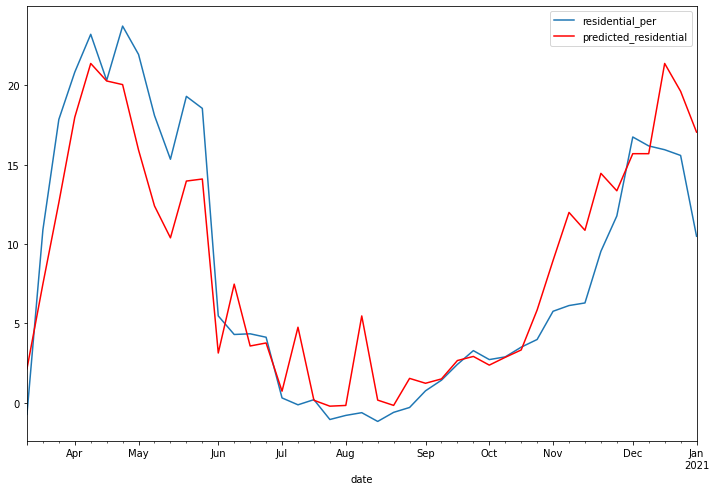

In [338]:
# Tahmin edilen ve gerçek değerlerin plot gösterimi

plt.rcParams['figure.figsize']=(12,8)

ax = plt.gca()

predict_df.plot(kind='line',x='date',y='residential_per',ax=ax)
predict_df.plot(kind='line',x='date',y='predicted_residential', color='red', ax=ax)

plt.show()

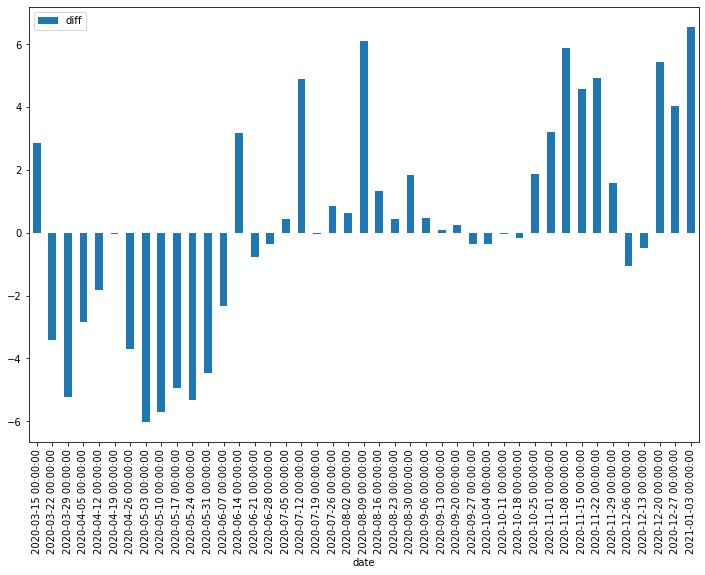

In [339]:
# Gerçek değerler ve tahmin edilen değerler arasındaki farkın bar plot ile gösterimi

plt.rcParams['figure.figsize']=(12,8)

ax = plt.gca()
predict_df['diff']=predict_df.predicted_residential - predict_df.residential_per
predict_df.plot('date', 'diff',kind='bar',ax=ax)
plt.show()

In [340]:
pred = X_test_predict['predicted_residential'].values
real = y_test.values

In [341]:
# Accuracy
errors = abs( pred - real)
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / pred)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 4.13 degrees.
Accuracy: 78.09 %.


In [342]:
# R^2 Score Hesabı
from sklearn.metrics import r2_score
R1Squared = r2_score(y_train[:, None], X_train_predict.values)
print(R1Squared)

0.8481420049107187


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



#### Random Forest Forecasting for Transit Stations

In [343]:
data_predict2 = data_weekly_mean2[['Cases','transit_stations']]

In [344]:
X1 = (data_predict2['Cases'])
y1 = (data_predict2['transit_stations'])

In [345]:
X1_train = X1[X1.index < "2020-12-10"]
y1_train = y1[y1.index < "2020-12-10"]

X1_test = X1[X1.index >= "2020-12-10"]
y1_test = y1[y1.index >= "2020-12-10"]
X1_test.values

array([5865.28571429, 4417.42857143, 3162.57142857, 2607.5       ])

In [346]:
## Random Forest modelini oluşturduk

Model2 = RandomForestRegressor(n_estimators=100, max_features=1,oob_score=True)
labels2 = y1_train
features2 = X1_train[:, None]

rf = Model.fit(features2,labels2)


## Modeli oluşturup fit ettikten sonra sonuçları görmek için dataframe oluşturduk
X1_test_predict=pd.DataFrame(
    rf.predict(X1_test[:, None])).rename(
    columns={0:'predicted_transit'})
X1_train_predict=pd.DataFrame(
    rf.predict(X1_train[:, None])).rename(
    columns={0:'predicted_transit'})

# görselleştirme ve karşılaştırma yapmak için residential ve vaka veri çerçevelerini birleştirdik
rf_predict = X1_train_predict.append(X1_test_predict)
rf_predict['date'] = data_predict2.index
rf_predict.set_index(['date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



,predicted_transit
date,
2020-03-15,-5.930396
2020-03-22,-15.729715
2020-03-29,-32.380644
2020-04-05,-52.756606
2020-04-12,-63.893000
2020-04-19,-62.467319
2020-04-26,-57.876206
2020-05-03,-49.355091
2020-05-10,-39.416126


In [347]:
## Tahmin edilen ve gerçek değerleri aynı dataframede birleştirdik
predict_df2 = pd.merge(rf_predict, data_predict2, how='inner', on='date') 
predict_df2.set_index(['date'])

,predicted_transit,Cases,transit_stations
date,,,
2020-03-15,-5.930396,3.600000,1.884592
2020-03-22,-15.729715,174.000000,-26.936937
2020-03-29,-32.380644,1140.142857,-53.018783
2020-04-05,-52.756606,2550.285714,-62.764514
2020-04-12,-63.893000,4269.571429,-69.331451
2020-04-19,-62.467319,4192.857143,-65.371227
2020-04-26,-57.876206,3403.428571,-69.154720
2020-05-03,-49.355091,2273.571429,-65.165367
2020-05-10,-39.416126,1801.714286,-58.164642


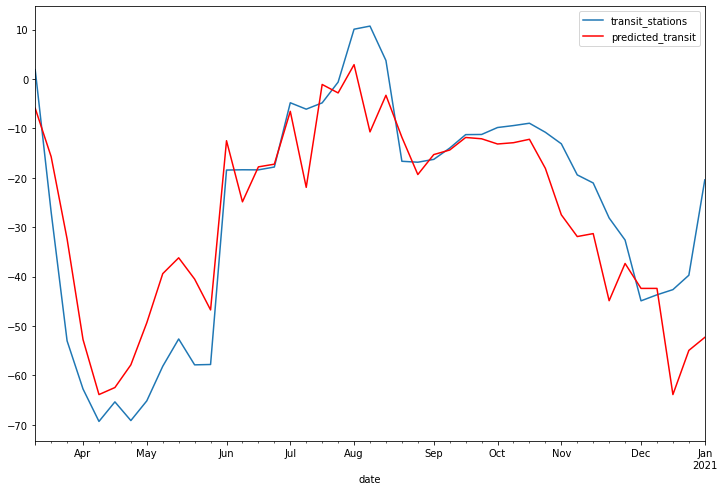

In [348]:
# Tahmin edilen ve gerçek değerlerin plot gösterimi

plt.rcParams['figure.figsize']=(12,8)

ax = plt.gca()

predict_df2.plot(kind='line',x='date',y='transit_stations',ax=ax)
predict_df2.plot(kind='line',x='date',y='predicted_transit', color='red', ax=ax)

plt.show()

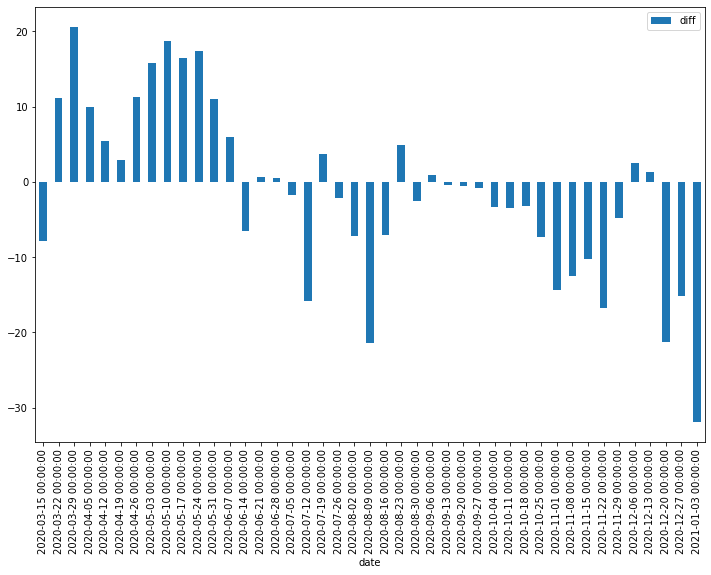

In [349]:
# Tahmin edilen ve gerçek değerlerin bar plot gösterimi

plt.rcParams['figure.figsize']=(12,8)

ax = plt.gca()
predict_df2['diff']=predict_df2.predicted_transit - predict_df2.transit_stations
predict_df2.plot('date', 'diff',kind='bar',ax=ax)
plt.show()

In [350]:
pred_ = X1_test_predict['predicted_transit'].values
real_ = y1_test.values

In [351]:
# Accuracy
errors = abs( pred_ - real_)
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * abs((errors / pred_))
print(mape)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 17.41 degrees.
[ 3.06427739 33.25357735 27.69314317 60.95725761]
Accuracy: 68.76 %.


In [352]:
# R^2 Score Hesabı

from sklearn.metrics import r2_score
RSquared = r2_score(y1_train[:, None], X1_train_predict.values)
print(RSquared)

0.8165097734900637


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



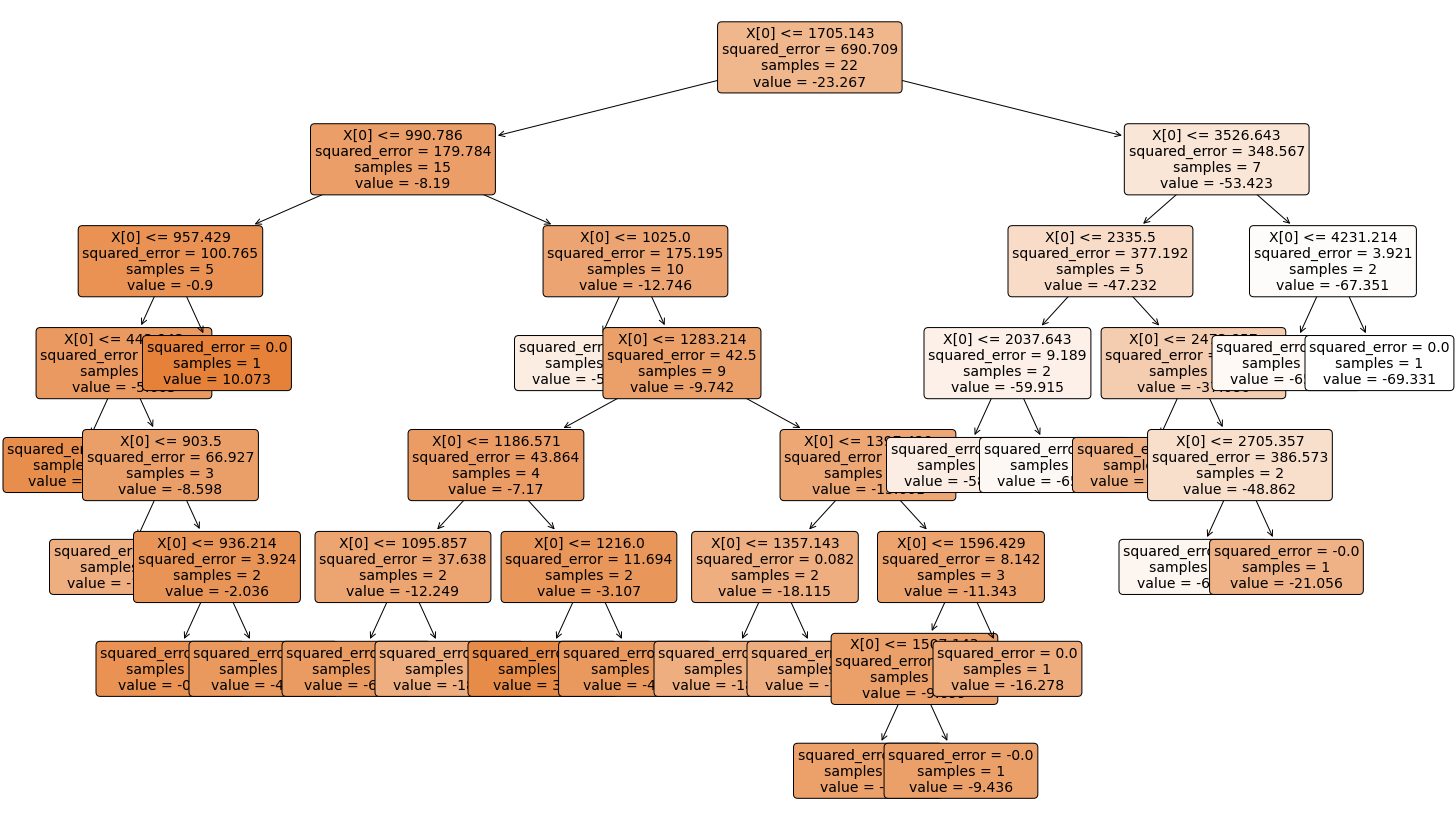

In [353]:
# Ağacın görselleştirilmesi
import pydot

Tree = rf.estimators_[5]

from sklearn import tree
plt.figure(figsize=(25,15))
tree.plot_tree(Tree,filled=True, 
              rounded=True, 
              fontsize=14);

**SONUÇ**

* Sonuç olarak bu projede; K-Means clustering yöntemi kullanarak vaka sayılarının transit ve residential değerlerine etkisini tarih bazında inceledik. Genel olarak gruplamalarda veriler toplu halde fakat bazı outlier değerler var, bunların da kapanmalardan dolayı olduğunu Sağlık Bakanlığının yayımladığı ve açıkladığı kapanma tarihlerine bakarak gördük ve tespit ettik. 

* Ayrıca yine iki veri için de Random Forest Regression yöntemini kullanarak ileriye dönük tarihlere göre tahmin yaptık. Doğruluk oranının daha çok eğitim verisi kullanılarak yapıldığında daha fazla olacağını düşünüyoruz. Yine de genel olarak tahmin edilen değerler ve gerçek değerler arasında uçuk farkların olmadığını görebiliriz.